In [1]:
!pip3 install torch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader 
from torch.utils.data import TensorDataset

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import random
import math

# Q1 gradient descent로 simple linear regression 추정하기

예제로 사용할 데이터 생성하기

$ y_i = \beta_0 + \beta_1 \times x_i + \epsilon_i \quad \epsilon_i \sim  iid N(0, 1)$ 

$ \beta_0 = 5, \beta_1 = 2$라는 모형을 따르는 데이터를 생성해준다. 

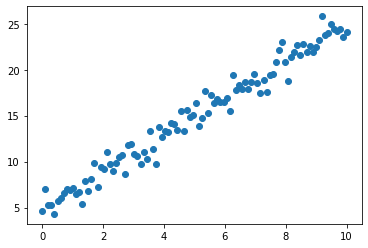

In [2]:
x_train_np = np.linspace(0, 10, 100).reshape(-1, 1)
y_train_np = 2 *  x_train_np + 5 + norm.rvs(0, 1, size = len(x_train_np)).reshape(-1, 1)

plt.scatter(x_train_np, y_train_np)
plt.show()

$ \hat{y_i} = \beta_0 + \beta_1 \times x_i $

$ \hat{y_i} = bias + weight \times x_i $

gradient descent를 사용해 bias와 weight를 학습해보자. 

1) 추정된 bias와 weight의 결과값은 얼마인가? 그래프를 그려 실제 회귀식에 가깝게 추정되었는지를 확인해보자. 

In [3]:
x_train = torch.FloatTensor(x_train_np)
y_train = torch.FloatTensor(y_train_np)

W = torch.zeros(1, requires_grad = True) # Weight
b = torch.zeros(1, requires_grad = True) # bias

optimizer = optim.SGD([W, b], lr = 0.01)

n_epochs = 1000
for epoch in range(n_epochs + 1):

  # H(x) 계산
  hypothesis = x_train *W +b   ###다른데???
  
  # cost 계산: MSE
  cost = torch.mean((hypothesis - y_train) ** 2)

  # cost로 H(x) 개선
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  if epoch % 100 == 0:
      print('Epoch {:4d}/{} W: {:.3f}, b: {:.3f} Cost: {:.6f}'.format(
          epoch, n_epochs, W.item(), b.item(), cost.item()
      ))

Epoch    0/1000 W: 1.835, b: 0.298 Cost: 258.277679
Epoch  100/1000 W: 2.419, b: 2.160 Cost: 2.882162
Epoch  200/1000 W: 2.261, b: 3.215 Cost: 1.712705
Epoch  300/1000 W: 2.164, b: 3.856 Cost: 1.280446
Epoch  400/1000 W: 2.106, b: 4.246 Cost: 1.120672
Epoch  500/1000 W: 2.070, b: 4.483 Cost: 1.061616
Epoch  600/1000 W: 2.048, b: 4.627 Cost: 1.039787
Epoch  700/1000 W: 2.035, b: 4.715 Cost: 1.031719
Epoch  800/1000 W: 2.027, b: 4.768 Cost: 1.028737
Epoch  900/1000 W: 2.022, b: 4.800 Cost: 1.027634
Epoch 1000/1000 W: 2.019, b: 4.820 Cost: 1.027227


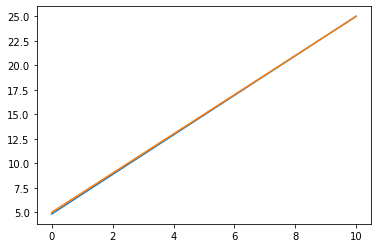

In [4]:
y_pred = W * x_train + b # 추정한 회귀식
y_real = 2 * x_train + 5 # 실제 회귀식

plt.plot(x_train_np, y_pred.detach().numpy())
plt.plot(x_train_np, y_real.detach().numpy())

2) learning rate를 0.03으로 조정해보자. 어떠한 문제가 발생하는가?

답: cost(MSE)가 최소가 되는 점을 찾지 못하고 발산한다. 

In [5]:
# 직접 W와 b를 정의하지 않고, nn.Module을 사용해 손쉽게 선형 모델을 생성할 수 있습니다. 
# 입출력값의 차원을 생각해 in_features와 out_features의 값을 적절하게 지정해주세요

in_features = 1 #x 하나
out_features = 1 #y 하나

model = nn.Linear(in_features = in_features, out_features = out_features, bias = True)

optimizer = optim.SGD(model.parameters(), lr = 0.03)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    hypothesis = model(x_train)
    
    # cost 계산
    cost = F.mse_loss(hypothesis, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        params = list(model.parameters())
        W = params[0].item()
        b = params[1].item()
        print('Epoch {:4d}/{} W: {:.3f}, b: {:.3f} Cost: {:.6f}'.format(
            epoch, nb_epochs, W, b, cost.item()
        ))

Epoch    0/1000 W: 6.314, b: 1.297 Cost: 431.791870
Epoch  100/1000 W: 796.228, b: 123.332 Cost: 19836280.000000
Epoch  200/1000 W: 171282.812, b: 25758.469 Cost: 922899906560.000000
Epoch  300/1000 W: 36945008.000, b: 5555061.500 Cost: 42938673548754944.000000
Epoch  400/1000 W: 7968936960.000, b: 1198211584.000 Cost: 1997735433156629102592.000000
Epoch  500/1000 W: 1718886596608.000, b: 258451898368.000 Cost: 92946188964906642092064768.000000
Epoch  600/1000 W: 370760501690368.000, b: 55747622731776.000 Cost: 4324378733877407276006622887936.000000
Epoch  700/1000 W: 79972230921977856.000, b: 12024636044738560.000 Cost: 201194095435029486889991736397922304.000000
Epoch  800/1000 W: 17249879487387009024.000, b: 2593694053853822976.000 Cost: inf
Epoch  900/1000 W: 3720779999491282436096.000, b: 559457587832146624512.000 Cost: inf
Epoch 1000/1000 W: 802567538446464117112832.000, b: 120674123152178280398848.000 Cost: inf


3) learning rate를 0.00000001로 조정해보자. 어떠한 문제가 발생하는가?

답: cost가 최소가 되는 점을 찾기까지 시간이 오래걸린다. epoch수를 늘리면 찾을수도 있지만 비효율적이다. 

In [6]:
W = torch.zeros(1, requires_grad = True) # Weight
b = torch.zeros(1, requires_grad = True) # bias

optimizer = optim.SGD([W, b], lr = 0.00000001)

n_epochs = 1000
for epoch in range(n_epochs + 1):

  # H(x) 계산
  hypothesis = x_train * W + b 
  
  # cost 계산: MSE
  cost = torch.mean((hypothesis - y_train)**2) 

  # cost로 H(x) 개선
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  if epoch % 100 == 0:
      print('Epoch {:4d}/{} W: {:.3f}, b: {:.3f} Cost: {:.6f}'.format(
          epoch, nb_epochs, W.item(), b.item(), cost.item()
      ))

Epoch    0/1000 W: 0.000, b: 0.000 Cost: 258.277679
Epoch  100/1000 W: 0.000, b: 0.000 Cost: 258.243073
Epoch  200/1000 W: 0.000, b: 0.000 Cost: 258.208527
Epoch  300/1000 W: 0.001, b: 0.000 Cost: 258.174011
Epoch  400/1000 W: 0.001, b: 0.000 Cost: 258.139435
Epoch  500/1000 W: 0.001, b: 0.000 Cost: 258.104889
Epoch  600/1000 W: 0.001, b: 0.000 Cost: 258.070374
Epoch  700/1000 W: 0.001, b: 0.000 Cost: 258.035828
Epoch  800/1000 W: 0.001, b: 0.000 Cost: 258.001282
Epoch  900/1000 W: 0.002, b: 0.000 Cost: 257.966766
Epoch 1000/1000 W: 0.002, b: 0.000 Cost: 257.932251


# Q2. train set and test set - MNIST

MNIST dataset을 불러온다. 

In [7]:
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

data_loader = DataLoader(dataset = mnist_train,
                         batch_size = 100, 
                         shuffle = True
                         )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



1) epoch 수를 15로 설정하여 trainset을 훈련시켜보자. 

그 후 훈련시킨 모델로 testset에 대한 평가를 진행해보자. 

In [8]:
# train model with train sets (0부터 9까지 손글씨 이미지, 이미지의 사이즈는 28*28)

# 입출력값의 차원을 생각해 in_features와 out_features의 값을 적절하게 지정해주세요

in_features = 28*28 #784
out_features = 10
linear = torch.nn.Linear(in_features = in_features, out_features=out_features, bias = True)

criterion = torch.nn.CrossEntropyLoss()    # Softmax is internally computed.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

training_epochs = 15

for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28)
        Y = Y

        # H(x) 계산
        hypothesis = linear(X)

        # cost 계산
        cost = criterion(hypothesis, Y)

        #cost로 H(x) 개선
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

Epoch: 0001 cost = 0.534479499
Epoch: 0002 cost = 0.358887315
Epoch: 0003 cost = 0.331256300
Epoch: 0004 cost = 0.316240579
Epoch: 0005 cost = 0.306514621
Epoch: 0006 cost = 0.300027102
Epoch: 0007 cost = 0.294707686
Epoch: 0008 cost = 0.290738583
Epoch: 0009 cost = 0.287282199
Epoch: 0010 cost = 0.284150928
Epoch: 0011 cost = 0.281810254
Epoch: 0012 cost = 0.279686362
Epoch: 0013 cost = 0.277786940
Epoch: 0014 cost = 0.276058286
Epoch: 0015 cost = 0.274399519


In [9]:
# Test the model using test sets
with torch.no_grad(): # torch.no_grad()를 사용하는 이유를 간단하게 설명해봅시다. >>> grad desc 계산하지 않겠다. train set 에 대해서만 파라미터 변경하면 됨. test set은 계산할 필요없음

    X_test = mnist_test.test_data.view(-1, 28 * 28).float()
    Y_test = mnist_test.test_labels

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())
    print('cost:', cost.item())

Accuracy: 0.882099986076355
cost: 0.13695596158504486


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


2) epoch 수를 30으로 설정하여 trainset을 훈련시켜보자. 

그 후 훈련시킨 모델로 testset에 대한 평가를 진행해보자. 

어떠한 문제가 발생하는가? overfitting 되어서 accuracy가 떨어질수도

In [10]:
linear = torch.nn.Linear(784, 10, bias = True)
criterion = torch.nn.CrossEntropyLoss()   
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

training_epochs = 30

for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        X = X.view(-1, 28 * 28)
        Y = Y

        # H(x) 계산
        hypothesis = linear(X)

        # cost 계산
        cost = criterion(hypothesis, Y)

        #cost로 H(x) 개선
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    if epoch % 5 == 0:
      print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

Epoch: 0001 cost = 0.536722600
Epoch: 0006 cost = 0.300200641
Epoch: 0011 cost = 0.281964332
Epoch: 0016 cost = 0.272776246
Epoch: 0021 cost = 0.267381698
Epoch: 0026 cost = 0.263321429


In [11]:
# Test the model using test sets
with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float()
    Y_test = mnist_test.test_labels

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    
    print('Accuracy:', accuracy.item()) 
    print('cost:', cost.item())

Accuracy: 0.8756999969482422
cost: 0.32270756363868713


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


# Q3. XOR problem with multilayer perceptron



In [12]:
X = torch.FloatTensor([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = torch.FloatTensor([[0], [1], [1], [0]])

# 입출력값의 차원을 고려하여 아래 빈칸을 적절하게 채워주세요
linear1 = torch.nn.Linear(2, 2, bias = True)
linear2 = torch.nn.Linear(2, 1, bias = True)
sigmoid = torch.nn.Sigmoid()

# 딥러닝의 구조를 고려하여 multi perceptron 모델을 적절하게 생성하세요. 
# nn.Sequential 함수를 사용하세요
model =  torch.nn.Sequential(linear1, sigmoid, linear2, sigmoid)

# 이 예제에서 cross entropy 대신 BCE를 사용하는 이유를 간단하게 설명하세요. 0 또는 1이 나와야하므로
criterion = torch.nn.BCELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr = 1)

for step in range(301):
  hypothesis = model(X)
  cost = criterion(hypothesis, Y)

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()
  if step%50 == 0:
    print(step, cost.item())

0 0.6956919431686401
50 0.6929630637168884
100 0.6927297115325928
150 0.6924248933792114
200 0.6919285655021667
250 0.6909742951393127
300 0.6887969374656677


##Q4. Sine Function Approximation using the Legendre *Polynomial*

n = 3일때 르장드르 다항식은 다음과 같다. \
$ P_{3} = \frac{1}{2} (5x^{3} -3x) $ \
이 함수를 사용하여, sine함수를 근사하도록 학습하려고 한다.


1) Forward, Backward 함수를 직접 작성하여보자.

In [13]:
# 이 클래스에서, forward, backward 함수가 하는 기능이 무엇인지 설명해주세요.

class Legendre3Function(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return 0.5 * (5 * input ** 3 - 3 * input)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        return grad_output * 0.5 * 3 * (5 * input ** 2 -1)
        # Hint : Legendre Polynomial의 differential

2) 학습을 위한 parameter와 Data를 세팅해보자.
   우리가 사용하려는 모델은 다음과 같다.\
   $ y = a + b * P_{3}(c + d * x) $

In [30]:
dtype = torch.float
device = torch.device("cpu")

x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x) # Target function to approximate

# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
a = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
b = torch.full((), -1.0, device=device, dtype=dtype, requires_grad=True)
c = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
d = torch.full((), 0.3, device=device, dtype=dtype, requires_grad=True)

3) 1)에서 정의한 forward, backward 함수를 사용하여,
   딥러닝 학습 과정을 직접 작성해보자.\
   \
   Learning rate의 경우, 5e-2, 5e-4, 5e-6, 5e-8 중,
   가장 적절한 Learning rate를 찾아보자. \
   적절한 learning rate보다 learning rate가 크거나 작을 때,
   어떤 현상이 발생하는지 살펴보자.

In [31]:
# [5e-2, 5e-4, 5e-6, 5e-8] 중 적절한 learning rate를 찾아주세요.
# 적절한 learning rate보다 learning rate가 크거나 작을 때, 어떤 차이가 생기는지
# 말씀해주세요.
learning_rate = 5e-6

# epoch = 2000
for t in range(2000):
    P3 = Legendre3Function.apply

    # Forward pass: predict y.
    # P3 using our custom backward function.
    y_pred = a + b * P3(c+d*x) 

    # Compute and print MSE loss
    loss = (y_pred - y).pow(2).sum().mean()
    if t % 100 == 0:
        print(t, loss.item())

    # Use autograd to compute the backward pass.
    loss.backward()

    # Update weights using gradient descent
    # Hint : use a, b, c, d, learning_rate, a.grad, b.grad, c.grad, d.grad
    with torch.no_grad():
        a -= learning_rate*a.grad
        b -= learning_rate*b.grad
        c -= learning_rate*c.grad
        d -= learning_rate*d.grad

        # Manually zero the gradients after updating weights
        a.grad = a.grad.zero_()
        b.grad = b.grad.zero_()
        c.grad = c.grad.zero_()
        d.grad = d.grad.zero_()

print(f'Result: y = {a.item()} + {b.item()} * P3({c.item()} + {d.item()} x)')

0 461.902587890625
100 209.16842651367188
200 144.1292266845703
300 100.34451293945312
400 70.7933349609375
500 50.81488037109375
600 37.29232406616211
700 28.13178253173828
800 21.92227554321289
900 17.71118927001953
1000 14.854462623596191
1100 12.915864944458008
1200 11.600122451782227
1300 10.70693302154541
1400 10.100505828857422
1500 9.68873119354248
1600 9.409082412719727
1700 9.219189643859863
1800 9.090229034423828
1900 9.002641677856445
Result: y = -5.394172664097141e-09 + -2.208526849746704 * P3(1.367587154632588e-09 + 0.2554861009120941 x)


##Q5. Different Basis Function for approximating sine function

이번에는 ReLu function을 사용하여 sine함수를 학습해보려 한다. \
ReLu function을 사용했을 때에도, 학습이 잘 되는지 살펴보자.

In [26]:
class ReLuFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[grad_input<0] = 0
        # Hint : reLu function의 도함수의 형태를 반영하면 됩니다.
        return grad_input

dtype = torch.float
device = torch.device("cpu")

x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# Our model : y = a + b * ReLu(c + d * x).
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
a = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
b = torch.full((), 1.0, device=device, dtype=dtype, requires_grad=True)
c = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
d = torch.full((), 1.0, device=device, dtype=dtype, requires_grad=True)

learning_rate = 5e-7
for t in range(2000):
    ReLu = ReLuFunction.apply

    # Forward pass: predict y.
    # ReLu using our custom backward function.
    y_pred = a + b * ReLu(c + d * x)

    # Compute and print MSE loss
    loss = (y_pred - y).pow(2).sum().mean()
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass.
    loss.backward()

    # Update weights using gradient descent
    # Hint : use a, b, c, d, learning_rate, a.grad, b.grad, c.grad, d.grad
    with torch.no_grad():
        a -= learning_rate*a.grad
        b -= learning_rate*b.grad
        c -= learning_rate*c.grad
        d -= learning_rate*d.grad

        # Manually zero the gradients after updating weights
        a.grad = a.grad.zero_()
        b.grad = b.grad.zero_()
        c.grad = c.grad.zero_()
        d.grad = d.grad.zero_()

print(f'Result: y = {a.item()} + {b.item()} * ReLu({c.item()} + {d.item()} x)')

99 1099.734130859375
199 781.990234375
299 675.8348388671875
399 639.0466918945312
499 628.66943359375
599 629.074462890625
699 633.9666748046875
799 640.66259765625
899 647.9852294921875
999 655.4149169921875
1099 662.7255249023438
1199 669.8223876953125
1299 676.67041015625
1399 683.2593383789062
1499 689.5903930664062
1599 695.6671142578125
1699 701.4951782226562
1799 707.080078125
1899 712.42626953125
1999 717.538818359375
Result: y = -0.28170058131217957 + 0.5593968033790588 * ReLu(-0.775858998298645 + 1.0392035245895386 x)


## Q6. 
Q4, Q5에서 학습한 결과를 바탕으로, 어떤 function을 사용하는 것이 학습에 더 적절했었는지 코멘트해주세요.
>>> ReLu는 적절하지 않았다

## Q7. Deep Learning Example

주어진 데이터를 로딩하고, 아래 코드의 빈칸을 채워
딥러닝 학습을 하는 코드를 완성하여보자.

In [ ]:
# 업로드 시간이 7분 30초 가량 걸리기에, 그동안 밑에 코드 작성 먼저 해주셔도 됩니다. (colab 사용시)
# colab 사용하시면, 주석 지우고 사용해주세요

# from google.colab import files
# uploaded = files.upload()

Saving testX.csv to testX.csv
Saving testY.csv to testY.csv
Saving trainX.csv to trainX.csv
Saving trainY.csv to trainY.csv


In [32]:
# Data Loading using pd.read_csv

train_X = pd.read_csv('trainX.csv', encoding = 'utf-8')
train_Y = pd.read_csv('trainY.csv', encoding = 'utf-8')

test_X = pd.read_csv('testX.csv', encoding = 'utf-8')
test_Y = pd.read_csv('testY.csv', encoding = 'utf-8')

In [33]:
# Data Setting
train_X = np.array(train_X)
train_Y = np.array(train_Y)

test_X = np.array(test_X)
test_Y = np.array(test_Y)

input_dim = len(train_X[0])

# Data type casting to torchTensor
train_x = torch.FloatTensor(train_X)
train_y = torch.FloatTensor(train_Y)

# Set batch size
batch_size = 4096
dataset = TensorDataset(train_x, train_y)

# DataLoader setting
# 셔플이 있고, batch size에 맞게 dataloader를 세팅해주세요,
dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)

In [34]:
# Model Setting
model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, int(input_dim/6)),
    # 각 Layer의 activation function을 설정해주세요.
    torch.nn.ReLU(), #linear activa 렐루
    # Hint : hidden layer activation function ReLu
    torch.nn.Linear(int(input_dim/6), int(input_dim/5)),
    torch.nn.ReLU(), #linear activa 렐루
    # Hint : hidden layer activation function ReLu
    torch.nn.Linear(int(input_dim/5), 1),
    torch.nn.Sigmoid(), #linear activa 렐루말고 다른거
    # Hint : Output layer activation function for binary classification
    )

In [35]:
params = list(model.parameters())
print("The number of parameters:", sum([p.numel() for p in model.parameters() if p.requires_grad]), "elements")
x = torch.from_numpy(train_X.astype(np.float32))
y = torch.from_numpy(train_Y.astype(np.float32)).view(-1, 1)

# loss function 부분을 채워주세요.
# BCE loss를 사용합니다.
loss_fn = torch.nn.BCELoss()

The number of parameters: 1977 elements


In [36]:
learning_rate = 1e-3
iter = 200
loss_list = []
# Adam optimizer를 설정해주세요. learning rate, 그리고 weight_decay는 5e-2로 설정해주세요.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-2)

prev_loss = 1e+30

for t in range(iter+1):
    for batch, sample in enumerate(dataloader):
      trainx, trainy = sample
      y_pred = model(trainx)

      loss = loss_fn(y_pred,trainy)

      # gradient 계산 및 gradient descent 계산을 통한 optimization 부분
      # 코드를 채워주세요.  초기화 back step 3줄
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
      loss_list.append(loss.item())

    cur_loss = np.mean(loss_list[max(0, len(loss_list)-batch-1):len(loss_list)-1])
    
    if t % 10 == 0:
      print('iter {}/{} loss: {:.4f}'.format(
             t, iter, cur_loss))

iter 0/200 loss: 0.6320
iter 10/200 loss: 0.5762
iter 20/200 loss: 0.5412
iter 30/200 loss: 0.5217
iter 40/200 loss: 0.5053
iter 50/200 loss: 0.4919
iter 60/200 loss: 0.4788
iter 70/200 loss: 0.4662
iter 80/200 loss: 0.4582
iter 90/200 loss: 0.4430
iter 100/200 loss: 0.4390
iter 110/200 loss: 0.4304
iter 120/200 loss: 0.4304
iter 130/200 loss: 0.4312
iter 140/200 loss: 0.4285
iter 150/200 loss: 0.4326
iter 160/200 loss: 0.4245
iter 170/200 loss: 0.4279
iter 180/200 loss: 0.4271
iter 190/200 loss: 0.4257
iter 200/200 loss: 0.4256


Weighted F1: 0.79468230081112


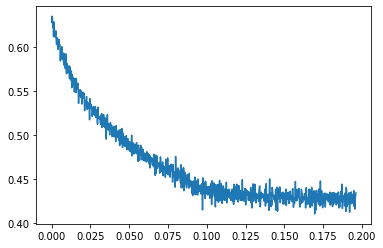

In [38]:
y_predict = model(torch.from_numpy(test_X.astype(np.float32)))
y_pred = y_predict.detach().numpy()

# test set의 prediction값을 계산하는 식을 작성하고, weighted f1 score를 계산해주세요.
y_pred = [1.0 if x > 0.5 else 0.0 for x in y_pred] #확률이 0.5보다 크면 1 작으면 0
result = f1_score(test_Y, y_pred, average="weighted") #2개가 들어감

# 결과물 출력
print("Weighted F1:", result)
step = np.linspace(0, len(loss_list), len(loss_list))
plt.plot(step/int(batch_size + 1), np.array(loss_list))